In [29]:
# 1. Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Import data produced by the preprocessing notebook
data = pd.read_pickle('../data/connectivity_compliance_matrices.pkl')
data.rename(columns={'ρ': 'rho'}, inplace=True)

# Calculate mean of E1, E2, E3
data['mean_E'] = data[['E1', 'E2', 'E3']].mean(axis=1)

# We will use only the compliance components as targets
# (3x3 normal block + shear diagonals)
compliance_comps = ['S11', 'S12', 'S13',
                    'S21', 'S22', 'S23',
                    'S31', 'S32', 'S33',
                    'S44', 'S55', 'S66']

# Extract relevant features:
#  - connectivity_matrix drives the graph structure
#  - compliance_components (12 entries) are regression targets
#  - compliance_matrix (full 6x6) is carried for evaluation/plotting
X = data[['connectivity_matrix', 'compliance_matrix',
          'compliance_components', 'rho', 'mean_E']]
display(X.head())


,connectivity_matrix,compliance_matrix,compliance_components,rho,mean_E
0,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[16.24421666, -4.390589664, -4.392122358, 0.0...","[16.24421666, -4.390589664, -4.392122358, -4.3...",0.3,0.061528
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22.19444352, -7.184492662, -7.167363015, 0.0...","[22.19444352, -7.184492662, -7.167363015, -7.1...",0.3,0.045108
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[21.44865816, -6.46782716, -6.446425604, 0.0,...","[21.44865816, -6.46782716, -6.446425604, -6.46...",0.3,0.046636
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[15.24763491, -3.931170891, -3.930385075, 0.0...","[15.24763491, -3.931170891, -3.930385075, -3.9...",0.3,0.065567
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[23.16273271, -5.511611079, -5.663410447, 0.0...","[23.16273271, -5.511611079, -5.663410447, -5.5...",0.3,0.043226


In [30]:
# 2. Graph Construction Utilities

# Helper: map 12 compliance components into a 6x6 matrix,
# setting all non-specified entries to zero.
def components_to_matrix(components):
    """
    components: array-like with 12 entries ordered as in compliance_comps.
    Returns a 6x6 NumPy array with zeros everywhere except the specified entries.
    """
    mat = np.zeros((6, 6), dtype=float)

    idx_map = {
        'S11': (0, 0),
        'S12': (0, 1),
        'S13': (0, 2),
        'S21': (1, 0),
        'S22': (1, 1),
        'S23': (1, 2),
        'S31': (2, 0),
        'S32': (2, 1),
        'S33': (2, 2),
        'S44': (3, 3),
        'S55': (4, 4),
        'S66': (5, 5),
    }

    for value, key in zip(components, compliance_comps):
        i, j = idx_map[key]
        mat[i, j] = value

    return mat

def construct_graph_data(row):
    conn_mat = row['connectivity_matrix']
    C_full = row['compliance_matrix']                           # full 6x6 ground truth
    C_vec_raw = np.array(row['compliance_components'], dtype=float)  # length-12

    rho = row['rho']
    mean_E = row['mean_E']

    # Per-sample min-max normalization of the 12 compliance components
    c_min = C_vec_raw.min()
    c_max = C_vec_raw.max()
    denom = c_max - c_min
    if denom == 0.0:
        C_vec_norm = np.zeros_like(C_vec_raw)
    else:
        C_vec_norm = (C_vec_raw - c_min) / denom

    # Build edge index from connectivity
    edge_index = np.array(np.nonzero(conn_mat)).T
    num_nodes = conn_mat.shape[0]

    # Node features: [rho, degree]
    rhos = np.array([rho] * num_nodes)
    num_neighbors = np.sum(conn_mat, axis=1)
    x = torch.tensor(np.column_stack((rhos, num_neighbors)), dtype=torch.float)

    graph_data = Data(
        x=x,
        edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
        y=torch.tensor(C_vec_norm, dtype=torch.float32),            # length-12 normalized target
        compliance_matrix=torch.tensor(C_full, dtype=torch.float32),# full 6x6 (unnormalized)
        comp_min=torch.tensor([c_min], dtype=torch.float32),        # for inverse/plot scaling
        comp_max=torch.tensor([c_max], dtype=torch.float32),
        mean_E=torch.tensor([mean_E], dtype=torch.float32)
    )
    return graph_data

# Preview individual sample / compliance components and matrices
sample = X.iloc[0]
conn_mat = sample['connectivity_matrix']
C_full_true = sample['compliance_matrix']
C_vec_raw = np.array(sample['compliance_components'], dtype=float)
edge_index = np.array(np.nonzero(conn_mat)).T
rho = sample['rho']

print("Compliance components (raw, 12 entries):", C_vec_raw)
print("True full 6x6 compliance matrix from data:")
print(C_full_true)

pred_style_mat_raw = components_to_matrix(C_vec_raw)
print("6x6 matrix built only from those 12 components (zeros elsewhere):")
print(pred_style_mat_raw)

sample_data = construct_graph_data(sample)
print(f"Edge index:\n{sample_data.edge_index}")
print(f"Compliance components as y (normalized):\n{sample_data.y}")


Compliance components (raw, 12 entries): [16.24421666 -4.39058966 -4.39212236 -4.39058966 16.25385263 -4.39220149
 -4.39212236 -4.39220149 16.26016853 38.95901512 39.07623774 39.01373283]
True full 6x6 compliance matrix from data:
[[16.24421666 -4.39058966 -4.39212236  0.          0.          0.        ]
 [-4.39058966 16.25385263 -4.39220149  0.          0.          0.        ]
 [-4.39212236 -4.39220149 16.26016853  0.          0.          0.        ]
 [ 0.          0.          0.         38.95901512  0.          0.        ]
 [ 0.          0.          0.          0.         39.07623774  0.        ]
 [ 0.          0.          0.          0.          0.         39.01373283]]
6x6 matrix built only from those 12 components (zeros elsewhere):
[[16.24421666 -4.39058966 -4.39212236  0.          0.          0.        ]
 [-4.39058966 16.25385263 -4.39220149  0.          0.          0.        ]
 [-4.39212236 -4.39220149 16.26016853  0.          0.          0.        ]
 [ 0.          0.          

In [31]:
# 3. Build Graph Dataset & Print Stats

graph_data_list = X.apply(construct_graph_data, axis=1).tolist()
print(f"Constructed {len(graph_data_list)} graph data objects.")

train_data, test_data = train_test_split(
    graph_data_list,
    test_size=0.2,
    random_state=42
)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")
print('len(y) per graph =', len(train_data[0].y))
print(train_data[0])

num_node_features = int(train_data[0].x.shape[1])   # features per node
output_dim = int(train_data[0].y.shape[0])         # number of compliance components (should be 12)
print(f"Node features per node: {num_node_features}")
print(f"Output dim (number of compliance components): {output_dim}")


Constructed 2624 graph data objects.
Training set size: 2099
Testing set size: 525
len(y) per graph = 12
Data(x=[11, 2], edge_index=[2, 21], y=[12], compliance_matrix=[6, 6], comp_min=[1], comp_max=[1], mean_E=[1])
Node features per node: 2
Output dim (number of compliance components): 12


In [32]:
# 4. GNN Model Definition

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

embedding_size = 64  # not strictly used

class GNN_v1(torch.nn.Module):
    """Graph-level regressor: N×GCNConv + configurable DNN."""
    def __init__(
        self,
        in_channels,
        embedding_size=128,
        out_dim=36,
        dropout=0.0,
        mlp_layers=1,
        hidden_neurons=64,
        num_convs=1,
        conv_channels=None
    ):
        super(GNN_v1, self).__init__()
        torch.manual_seed(42)

        if conv_channels is not None:
            widths = list(map(int, conv_channels))
            assert len(widths) >= 1, "conv_channels must have at least one width"
        else:
            widths = [int(embedding_size)] * max(int(num_convs), 1)

        convs = []
        in_c = in_channels
        for w in widths:
            convs.append(GCNConv(in_c, w))
            in_c = w
        self.convs = torch.nn.ModuleList(convs)

        self.dropout = Dropout(dropout)
        last_embed = widths[-1]
        d_in = last_embed * 2  # concat of [gmp, gap]
        hdim = last_embed if hidden_neurons is None else int(hidden_neurons)

        layers = []
        if mlp_layers <= 0:
            layers.append(Linear(d_in, out_dim))
        else:
            layers += [Linear(d_in, hdim), torch.nn.ReLU(), Dropout(dropout)]
            for _ in range(mlp_layers - 1):
                layers += [Linear(hdim, hdim), torch.nn.ReLU(), Dropout(dropout)]
            layers.append(Linear(hdim, out_dim))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        h = x
        for conv in self.convs:
            h = conv(h, edge_index)
            h = F.relu(h)
        hg = torch.cat([gmp(h, batch), gap(h, batch)], dim=1)
        hg = self.dropout(hg)
        out = self.mlp(hg)  # [batch_size, out_dim] -> here out_dim = 12
        return out


Starting training...
Epoch 0 | Train MSE 0.318650
Epoch 5 | Train MSE 0.019374
Epoch 10 | Train MSE 0.018719
Epoch 15 | Train MSE 0.018208
Epoch 20 | Train MSE 0.017710
Epoch 25 | Train MSE 0.017283
Epoch 30 | Train MSE 0.016899
Epoch 35 | Train MSE 0.016576
Epoch 40 | Train MSE 0.016297
Epoch 45 | Train MSE 0.016088
Epoch 50 | Train MSE 0.015899
Epoch 55 | Train MSE 0.015757
Epoch 60 | Train MSE 0.015597
Epoch 65 | Train MSE 0.015515
Epoch 70 | Train MSE 0.015428
Epoch 75 | Train MSE 0.015362
Epoch 80 | Train MSE 0.015298
Epoch 85 | Train MSE 0.015335
Epoch 90 | Train MSE 0.015234
Epoch 95 | Train MSE 0.015210


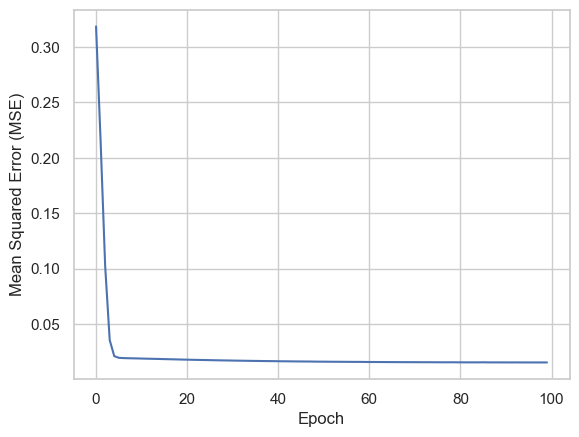

In [33]:
# 5. Training Setup and Loop

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

model = GNN_v1(
    in_channels=num_node_features,
    embedding_size=128,
    out_dim=output_dim,   # equals 12 (number of components)
    dropout=0.0,
    mlp_layers=1,
    hidden_neurons=64,
    num_convs=1
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_GRAPHS_PER_BATCH = 32
train_loader = DataLoader(train_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

def train_epoch(loader):
    model.train()
    total_squared_error = 0.0
    total_elements = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        target = batch.y.view_as(pred).to(device)  # both are [B, 12] (normalized)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()

        batch_se = F.mse_loss(pred, target, reduction='sum').item()
        total_squared_error += batch_se
        total_elements += pred.numel()

    return total_squared_error / total_elements if total_elements > 0 else float('nan')

print("Starting training...")
losses = []
EPOCHS = 100
for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader)
    losses.append(train_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Train MSE {train_loss:.6f}")

# Training loss plot
sns.set(style="whitegrid")
loss_indices = list(range(len(losses)))
ax = sns.lineplot(x=loss_indices, y=losses)
ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
plt.show()


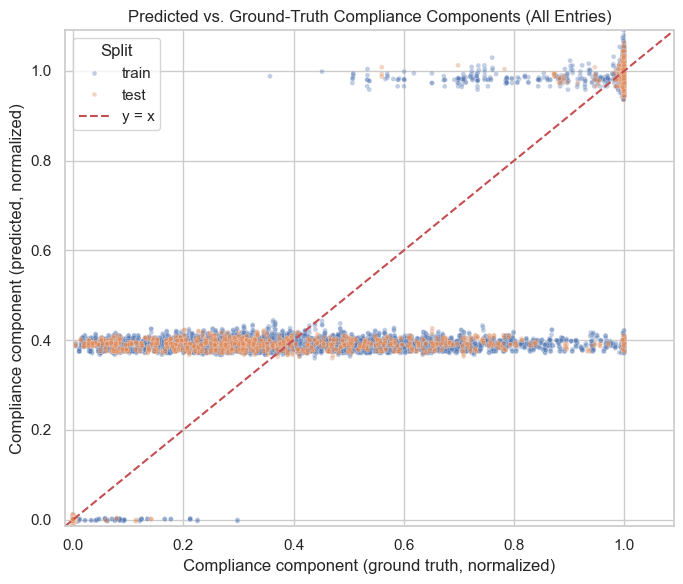

In [34]:
# 6. Evaluation and Prediction Plotting

def evaluate_split(loader, split_name, model, device):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)                     # [B, 12] normalized
            target = batch.y.view_as(pred)          # [B, 12] normalized
            p = pred.detach().cpu().numpy().ravel()
            t = target.detach().cpu().numpy().ravel()
            ys.append(t)
            preds.append(p)

    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)
    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "split": split_name
    })
    return df

train_df = evaluate_split(train_loader, "train", model, device)
test_df  = evaluate_split(test_loader,  "test",  model, device)
comb_df  = pd.concat([train_df, test_df], ignore_index=True)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(
    data=comb_df,
    x="y_true",
    y="y_pred",
    hue="split",
    alpha=0.35,
    s=12,
    ax=ax
)
xy_min = float(min(comb_df["y_true"].min(), comb_df["y_pred"].min()))
xy_max = float(max(comb_df["y_true"].max(), comb_df["y_pred"].max()))
ax.axline((0, 0), slope=1.0, color="r", linestyle="--", linewidth=1.5, label="y = x")
ax.set_xlim(xy_min, xy_max)
ax.set_ylim(xy_min, xy_max)
ax.set_xlabel("Compliance component (ground truth, normalized)")
ax.set_ylabel("Compliance component (predicted, normalized)")
ax.legend(title="Split")
ax.set_title("Predicted vs. Ground-Truth Compliance Components (All Entries)")
plt.tight_layout()
plt.show()


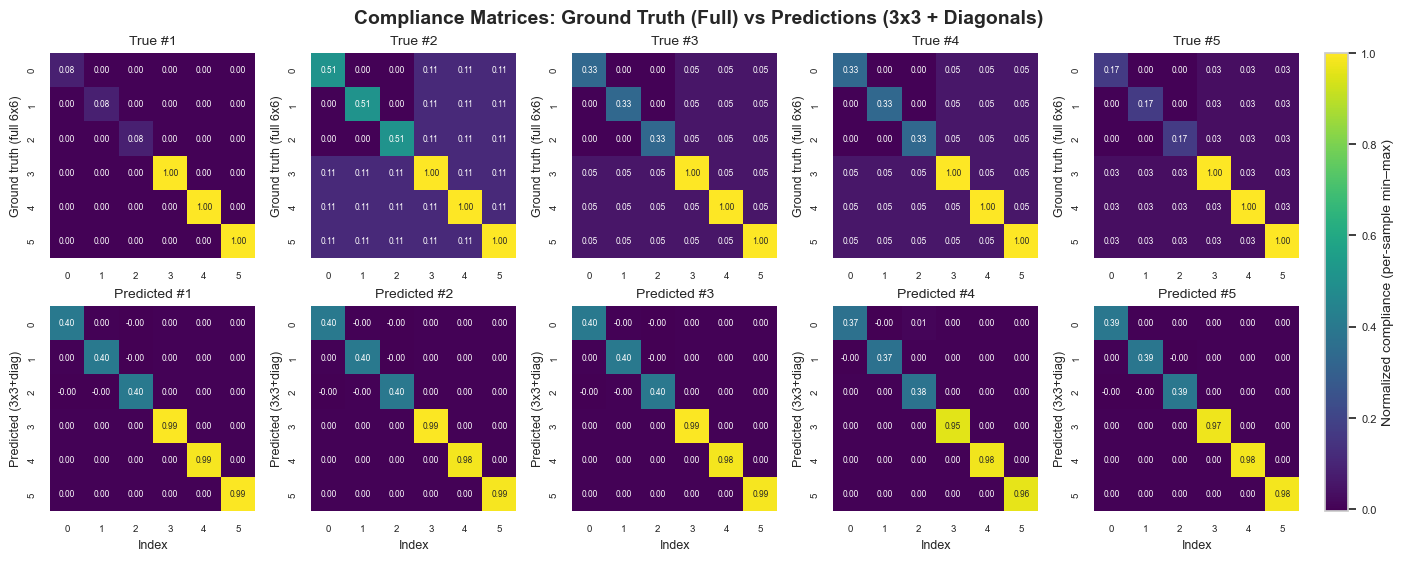

In [35]:
# 7. Visualize Predicted vs True Compliance Matrices (5 examples)

from torch_geometric.data import Batch  # add this import if not already present

def visualize_compliance_matrices(
    model,
    dataset,
    device,
    num_examples=5,
    annot=True,
    fmt=".2f"
):
    """
    Sample `num_examples` graphs from `dataset` and plot
    ground-truth vs predicted compliance matrices as heatmaps.

    - Model predicts 12 normalized components per graph.
    - For each sample, those 12 are min-max normalized using that
      sample's components (stored as comp_min / comp_max).
    - The full 6x6 ground-truth compliance matrix is also normalized
      with the same per-sample min/max before plotting.
    - Entries not in compliance_comps are taken from the true matrix
      but never directly predicted.
    """
    model.eval()

    if len(dataset) == 0:
        print("Dataset is empty; nothing to visualize.")
        return

    num_examples = min(num_examples, len(dataset))
    indices = np.random.choice(len(dataset), size=num_examples, replace=False)
    samples = [dataset[i] for i in indices]

    batch = Batch.from_data_list(samples).to(device)

    with torch.no_grad():
        # Forward pass: [num_examples, 12] (normalized predictions)
        pred_all = model(batch).cpu().numpy()

    true_mats = []
    pred_mats = []
    for i, data_item in enumerate(samples):
        true_full = data_item.compliance_matrix.cpu().numpy()   # full 6x6 (raw)
        c_min = float(data_item.comp_min.item())
        c_max = float(data_item.comp_max.item())
        denom = c_max - c_min if c_max > c_min else 1.0

        # Normalize true full matrix with same per-sample min/max
        true_full_norm = (true_full - c_min) / denom

        # Predicted 12-component vector is already normalized;
        # place it into a 6x6 sparse matrix
        pred_vec_norm = pred_all[i]
        pred_mat_norm = components_to_matrix(pred_vec_norm)

        true_mats.append(true_full_norm)
        pred_mats.append(pred_mat_norm)

    # Shared color scale across all matrices
    all_vals = np.concatenate([m.ravel() for m in (true_mats + pred_mats)])
    vmin = all_vals.min()
    vmax = all_vals.max()

    fig, axes = plt.subplots(
        2,
        num_examples,
        figsize=(2.8 * num_examples, 5.5),
        constrained_layout=True
    )

    if num_examples == 1:
        axes = np.array(axes).reshape(2, 1)

    im_for_cbar = None
    annot_kws = {"fontsize": 6} if annot else None

    for i, (true_mat, pred_mat) in enumerate(zip(true_mats, pred_mats)):
        ax_true = axes[0, i]
        ax_pred = axes[1, i]

        im_true = sns.heatmap(
            true_mat,
            ax=ax_true,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=annot,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_true.set_title(f"True #{i+1}", fontsize=10)
        ax_true.set_xlabel("")
        ax_true.set_ylabel("Ground truth (full 6x6)", fontsize=9)
        ax_true.tick_params(axis="both", labelsize=7)

        im_pred = sns.heatmap(
            pred_mat,
            ax=ax_pred,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=annot,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_pred.set_title(f"Predicted #{i+1}", fontsize=10)
        ax_pred.set_xlabel("Index", fontsize=9)
        ax_pred.set_ylabel("Predicted (3x3+diag)", fontsize=9)
        ax_pred.tick_params(axis="both", labelsize=7)

        if im_for_cbar is None:
            im_for_cbar = im_true.collections[0]

    cbar = fig.colorbar(
        im_for_cbar,
        ax=axes.ravel().tolist(),
        fraction=0.035,
        pad=0.02
    )
    cbar.set_label("Normalized compliance (per-sample min–max)", fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    fig.suptitle(
        "Compliance Matrices: Ground Truth (Full) vs Predictions (3x3 + Diagonals)",
        fontsize=14,
        weight="bold"
    )
    plt.show()


# Call this after training to visualize some test examples
# For fastest plotting, set annot=False
visualize_compliance_matrices(model, test_data, device, num_examples=5, annot=True)
